In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

from itertools import combinations

import warnings
import re

from utils import CLRS
import utils

params = {
    'axes.titlesize': 16, 
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12}

plb.rcParams.update(params)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_palette("muted")

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Load Data

Machine Predictive Maintenance Classification Dataset <br>
Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, <br>
we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

The dataset consists of 10 000 data points

| Column | Description |
| --- | --- |
UID | unique identifier ranging from 1 to 10000 |
Product ID | consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number |
Air temperature [K] | generated using a random walk process later normalized to a standard deviation of 2 K around 300 K |
Process temperature [K] | generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
Rotational speed [rpm] | calculated from powepower of 2860 W, overlaid with a normally distributed noise
Torque [Nm] | torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
Tool wear [min] | The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
Target | label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.



Important : There are two Targets - Do not make the mistake of using one of them as feature, as it will lead to leakage.
- Target : Failure or Not
- Failure Type : Type of Failure

Acknowledgements
UCI : https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [2]:
df = pd.read_csv('machine_predictive_maintenance.csv', index_col='UDI')
print(df.shape)
display(df.head(3))

(10000, 9)


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
UDI,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure


In [3]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [4]:
df.nunique()

Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
dtype: int64

# Initial Preprocessing

1. Check and fix data types and remove duplicates
2. Check and fix missing and unlikely values
3. Sanity checks

In [5]:
# REMOVE UNITS
# TODO: XGBoost does not allow brackets, just replace with parenthesis
df.columns = [re.sub(r'\[.+?\]\s*', '', x).strip() for x in df.columns]

#### Check and fix data types and remove duplicates

In [6]:
# CHECK DATA TYPES
display(df.dtypes)

# CHECK DUPLICATES
print('No. of duplicated records across all columns: ', df.duplicated().sum())
df.drop_duplicates(inplace=True)

Product ID              object
Type                    object
Air temperature        float64
Process temperature    float64
Rotational speed         int64
Torque                 float64
Tool wear                int64
Target                   int64
Failure Type            object
dtype: object

No. of duplicated records across all columns:  0


#### Check for and fix missing and unlikely values

In [7]:
# CHECK FOR MISSING VALUES
def get_percent_null(df):
    x = df.isnull().sum()*100 / len(df)
    return display(x[x>0].to_frame('precent_nulls'))

get_percent_null(df)

na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', 
    '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 
    'NaN', 'n/a', 'nan', 'null', 'None', 'none', 'na']

print('Check if there are other types of missing values:')
for x in na_values:
    df_ = (df == x).sum()
    if df_.sum() > 0:
        print(f'The ff column(s): {df_[df_ > 0].index.to_list()} contain(s) ', f'"{x}"') 

,precent_nulls


Check if there are other types of missing values:


In [8]:
# CHECK FOR UNLIKELY VALUES
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


#### Sanity checks 

- Check outliers from expected acceptable measurements

#### Misc.

In [9]:
# DROP NON-USEFUL COLUMNS
df.drop(['Product ID', 'Failure Type'], axis=1, inplace=True)

In [10]:
# NOTE: Class imbalanced; choose proper eval metric(s), oversample minority class (?), ~10% min class
df.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

# Exploratory Data Analysis

In [11]:
df.head(2)

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
UDI,,,,,,,
1,M,298.1,308.6,1551,42.8,0,0
2,L,298.2,308.7,1408,46.3,3,0


In [12]:
# Separate/group columns
c = df.dtypes == object

TARGET_COL = 'Target'
NUM_COLS   = list(df.select_dtypes(include=np.number).columns)
CAT_COLS   = list(c[c].index)

NUM_COLS.remove(TARGET_COL)

DROP_COLS_CANDIDATES = set()

## Relationships Among Numeric Features and Target Variable

### Correlation Among Features

,Process temperature,Torque
Air temperature,0.86,NaN
Rotational speed,NaN,-0.92


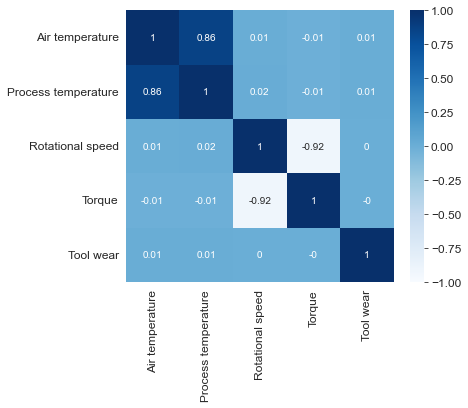

In [13]:
fig = plt.figure(figsize=(6,5))
df_ = df[NUM_COLS].corr(method='spearman').round(2)
ax = sns.heatmap(df_, annot=True, vmin=-1, vmax=1, cbar=True, cmap='Blues')

df_ = utils.get_trunc_corr_df(df_, 0.7)
df_

- Air temperature and Process temparature are highly correlated. 
- Rotational speed and Torque are highly correlated

In [14]:
DROP_COLS_CANDIDATES.update(['Air temperature', 'Rotational speed'])

### Measure Strength of Association of each Feature with Target Variable

In [15]:
# TODO: add correlation rank biserial correlation, chi square etc

### Distribution of Features

Air temperature skewness = 0.11
Process temperature skewness = 0.02
Rotational speed skewness = 1.99
Torque skewness = -0.01
Tool wear skewness = 0.03


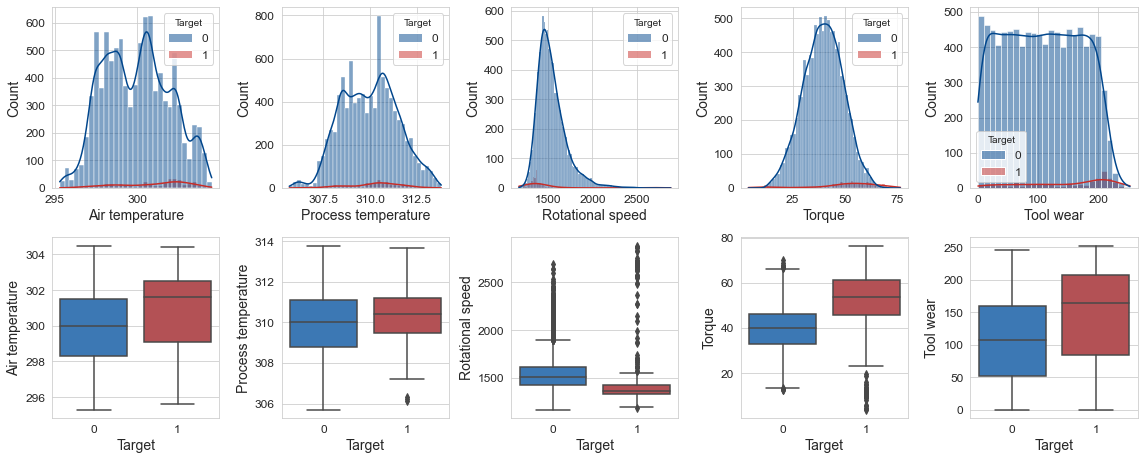

In [16]:
fig, axes = plt.subplots(2, 5, figsize=[16,6.5])

for i, c in enumerate(NUM_COLS):
    sns.histplot(data=df, x=c, kde=True, ax=axes[0,i], hue='Target', palette=[CLRS['blue'],CLRS['red']])
    sns.boxplot(data=df, y=c, x='Target', ax=axes[1,i], palette=[CLRS['lblue'],CLRS['lred']])
    print('{} skewness = {}'.format(c, round(df[c].skew(), 2)))
    
plt.tight_layout()

# TODO: How to interpret skewness and kurtosis

- It seems that failure occurs at higher value except for rotational speed which is just inversely proportional to torque
- There are visible differences in the distribution of features in each target class which is good

### Check which pairs of features separate the data well

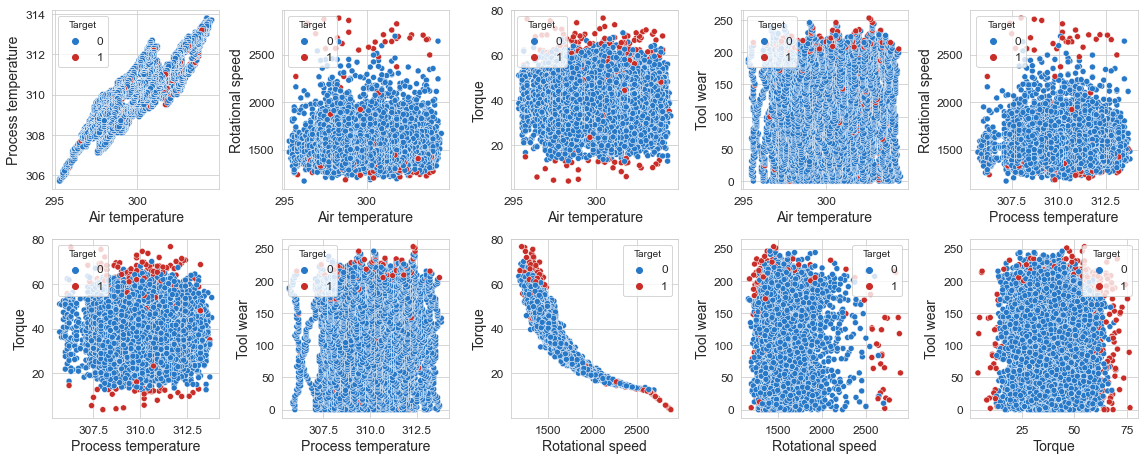

In [17]:
fig, axs = plt.subplots(2, 5, figsize=(16,6.5))
axs = axs.flatten()
for i, c in enumerate(combinations(NUM_COLS, 2)):
    sns.scatterplot(data=df, x=c[0], y=c[1], ax=axs[i], hue = 'Target', palette=[CLRS['lblue'],CLRS['red']])
fig.tight_layout()

## Relationships Among Categorical Features and Target Variable

### Measure Strength of Association of each Feature with Target Variable

- Cramer's V; Rule of thumb for strength of association -- Deg. of freedom = 1; > 0.1 - Weak, > 0.3 - Medium, > 0.5 - Strong
- NOTE: V has different threshold depending on usecase

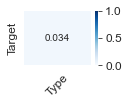

In [18]:
cv_corr = []
for c in CAT_COLS:
    cv_corr.append(utils.cramers_corrected_stat(pd.crosstab(df[c], df[TARGET_COL])))
fig = plt.figure(figsize=(1.5*len(CAT_COLS),1))
ax = sns.heatmap(
    pd.DataFrame(cv_corr, index=CAT_COLS, columns=[TARGET_COL]).sort_values(by=TARGET_COL).T, 
    vmin=0, vmax=1, annot=True, cbar=True, cmap='Blues')
x = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [19]:
x = df.groupby('Type')['Target'].size().to_frame('num_total')
y = df.groupby('Type')['Target'].sum().to_frame('num_failures')
z = pd.DataFrame(100 * (y.values/x.values).round(4), columns=['pct_failures'], index=x.index)
x.join(y).join(z)

,num_total,num_failures,pct_failures
Type,,,
H,1003,21,2.09
L,6000,235,3.92
M,2997,83,2.77


- As expected, there are higher percentage of failure for lower quality product

## Key Takeaways, Recommendations and Next Steps for EDA
- No major cleaning for the data since it is synthetic and properly generated
- The features in the dataset seems to be 

# Modeling

In [20]:
import pickle

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import (precision_score, recall_score, 
    f1_score, log_loss, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc) # --- not used
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import catboost as CB
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

import shap
from imblearn.combine import SMOTEENN, SMOTETomek

In [21]:
df.head(2)

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
UDI,,,,,,,
1,M,298.1,308.6,1551,42.8,0,0
2,L,298.2,308.7,1408,46.3,3,0


## Preprocess Data
1. Handle Outliers
2. Encode/Transform Data
3. Drop Highly Correlated Features
4. Scale data

In [22]:
# HANDLE OUTLIERS
OUTLR_COLS = ['Rotational speed', 'Torque']
boxcox_tx = PowerTransformer(method='box-cox', standardize=False)
df[OUTLR_COLS] = boxcox_tx.fit_transform(df[OUTLR_COLS])

# ENCODE/TRANFORM DATA
df['Type'].replace({'L':0, 'M':1, 'H':2}, inplace=True)

# DROP HIGHLY CORRELATED FEATURES
#

# Z-SCORE NORMALIZE DATA
df[NUM_COLS] = StandardScaler().fit_transform(df[NUM_COLS])

## Choose Baseline Model

1. Feature combinations to try: [NUM_COLS + CAT_COLS], [NUM_COLS - DROP_COLS_CANDIDATES + CAT_COLS]
2. ML Classifiers to try: LogisticRegression, CATBoost, XGBoost, RandomForest, SVM
3. Evalutaion metrics to try: Precision, Recall, F1, Log Loss, PR-AUC

### Split Data into Train Set and Test Set
- 80-20 split

In [23]:
x_train, x_test, y_train, y_test = \
    train_test_split(
        df[NUM_COLS+CAT_COLS], df[TARGET_COL], test_size = 0.2, random_state = 100
                )

sum(y_test)/len(y_test), sum(y_train)/len(y_train)

(0.0345, 0.03375)

In [24]:
# OVER-SAMPLE AND UNDER-SAMPLE THE TRAIN SET
# According to the user guide, ENN tends to clean more noisy samples than Tomek
# smote_enn = SMOTEENN(random_state=42) 

# x_train, y_train = smote_enn.fit_resample(x_train, y_train)

### Train Baseline Models

In [25]:
# TODO: Add LightGBM Classifier

LR_clf  = LogisticRegression(random_state = 100)
CB_clf  = CB.CatBoostClassifier(random_state = 100, verbose=False)
XGB_clf = XGBClassifier(random_state = 100)
RF_clf  = RandomForestClassifier(random_state = 100)
SVM_clf = SVC(random_state = 100)

classifiers  = {'LR_clf': LR_clf, 'CB_clf': CB_clf, 'XGB_clf': XGB_clf, 'RF_clf': RF_clf, 'SVM_clf': SVM_clf}
eval_metrics = {'precision': precision_score, 'recall': recall_score, 'f1': f1_score, 
                'neg_log_loss': log_loss, 'pr_auc': utils.pr_auc_score}
feature_sets = {'feat_set1': NUM_COLS + CAT_COLS, 
                'feat_set2': list(set(NUM_COLS) - DROP_COLS_CANDIDATES) + CAT_COLS}

print(len(feature_sets['feat_set1']), len(feature_sets['feat_set2']), sep=' | ')

6 | 4


In [26]:
clf_performance = {}

for featr_k, featr_v in feature_sets.items():
    x_train_ = x_train[featr_v]
    x_test_ = x_test[featr_v]

    clfs = {}
    for clf_k, clf_v in classifiers.items():
        clf_v = clf_v.fit(x_train_, y_train)
        y_pred = clf_v.predict(x_test_)

        eval_scores = {}
        for metric_k, metric_v in eval_metrics.items():
            eval_scores.update({metric_k:metric_v(y_test, y_pred)})
        
        clfs.update({clf_k:eval_scores})

    clf_performance.update({featr_k:clfs})

del x_train_, x_test_, clfs, eval_scores  

### Evaluate Models and Choose Final Model(s)

TODO: 
- Should baseline model be chosen based on training performance or test or both? Are there metrics to consider both?


In [27]:
perf_df = pd.DataFrame.from_dict(
    {(i,j): clf_performance[i][j] 
        for i in clf_performance.keys() 
        for j in clf_performance[i].keys()},
    orient='columns').round(3)
perf_df

feat_set1                               feat_set2                 \
                LR_clf CB_clf XGB_clf RF_clf SVM_clf    LR_clf CB_clf XGB_clf   
precision        1.000  0.922   0.895  0.902   1.000     1.000  0.786   0.681   
recall           0.116  0.681   0.739  0.667   0.232     0.029  0.478   0.464   
f1               0.208  0.783   0.810  0.767   0.376     0.056  0.595   0.552   
neg_log_loss     1.053  0.449   0.414  0.484   0.915     1.157  0.777   0.898   
pr_auc           0.573  0.807   0.821  0.790   0.629     0.531  0.641   0.582   

                             
             RF_clf SVM_clf  
precision     0.846   1.000  
recall        0.478   0.174  
f1            0.611   0.296  
neg_log_loss  0.725   0.984  
pr_auc        0.671   0.601

- The best performing base model is XGBoost (4/5 metrics) although CatBoost and RandomForest are close. 
    - We'll do hyperparameter tuning for the 3
    - [Tree-based models generally perform well for imbalanced dataset.](https://stackoverflow.com/questions/46104173/why-decision-tree-works-perfect-on-imbalanced-data#:~:text=For%20simple%20classifiers%20using%20linear%20regression%2C%20such%20as,the%20model%20sorts%20all%20samples%20into%20most%20label.)
- LogisticRegression generally performed worst.

## Final Model

- Feature selection 
    - recursive feature elimination (RFE)
    - TODO: Try other [methods](https://scikit-learn.org/stable/modules/feature_selection.html)
- GridSeachCV (hyperparameter tuning + cross validation)

### Feature Selection

In [28]:
feature_set = 'feat_set2'
final_model = XGB_clf

rfecv = RFECV(
    estimator=final_model,
    step=1,
    cv=5,
    scoring='f1',
    min_features_to_select=1,
)
rfecv.fit(x_train, y_train)

print(rfecv.n_features_)

# Columns to drop
drop_cols = [feature_sets[feature_set][i] for i,j in enumerate(rfecv.ranking_ != 1) if j]
print(drop_cols)

if not drop_cols:
    x_train.drop(drop_cols, axis=1, inplace=True)
    x_test.drop(drop_cols, axis=1, inplace=True)

6
[]


- Optimal number of features:

### Hyperparameter Tuning

In [29]:
# GridSearchCV

CB_param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.05, 0.10, 0.15],
    'max_depth': [4, 6, 8]}

XGB_param_grid = {
    'learning_rate': [0.05, 0.10, 0.15],
    'max_depth': [4, 6, 8],
    'booster':['gblinear', 'gbtree', 'dart']}

RF_param_grid = { 
    'n_estimators': [100, 200, 400],
    'max_depth' : [4, 6, 8],
    'criterion' :['gini', 'entropy']}

param_grids = {'CB_clf':CB_param_grid, 'XGB_clf':XGB_param_grid, 'RF_clf':RF_param_grid}
base_models = ['CB_clf', 'XGB_clf', 'RF_clf']

# TODO: Try multiple metrics during grid search
def gscv_helper(X, y, model, param_grid, **kwargs):
    gscv = GridSearchCV(
        estimator=model, 
        param_grid=param_grid,
        scoring=list(eval_metrics.keys())[:-1],
        refit='f1',
        return_train_score=True)
    return gscv.fit(X, y)

In [30]:
perf_gscv_df = {}
modl_gscv_df = {}
for k in base_models:
    m = gscv_helper(x_train, y_train, classifiers[k], param_grids[k])
    y = m.predict(x_test)

    eval_scores = {}
    for metric_k, metric_v in eval_metrics.items():
        eval_scores.update({metric_k:round(metric_v(y_test, y),3)})

    perf_gscv_df.update({k:eval_scores})
    modl_gscv_df.update({k:[m,y]})

In [31]:
# Tuned nmodels performance
tuned_perf_df = pd.DataFrame.from_dict(
    {(i): perf_gscv_df[i] for i in perf_gscv_df.keys()}, 
    orient='index').T
tuned_perf_df

,CB_clf,XGB_clf,RF_clf
precision,0.870,0.926,0.946
recall,0.681,0.725,0.507
f1,0.764,0.813,0.660
neg_log_loss,0.501,0.397,0.622
pr_auc,0.781,0.830,0.735


In [32]:
# Base models performance
perf_df['feat_set1'][base_models]

,CB_clf,XGB_clf,RF_clf
precision,0.922,0.895,0.902
recall,0.681,0.739,0.667
f1,0.783,0.810,0.767
neg_log_loss,0.449,0.414,0.484
pr_auc,0.807,0.821,0.790


- CatBoost had better improvement
- TODO: Tune XGBoost (and the rest) even more

## Evaluate/ Validate Model/ Check Scalability

In [33]:
tuned_perf_df.XGB_clf.to_dict()

{'precision': 0.926,
 'recall': 0.725,
 'f1': 0.813,
 'neg_log_loss': 0.397,
 'pr_auc': 0.83}

### Plot train vs test performance

- no overfitting
- TODO: Do more in terms of checking if model overfitted e.g. check bias and variance of the model?

In [34]:
gscv_res = modl_gscv_df['XGB_clf'][0]
final_model = gscv_res.best_estimator_
y_pred = modl_gscv_df['XGB_clf'][1]
gscv_res.best_params_

{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 6}

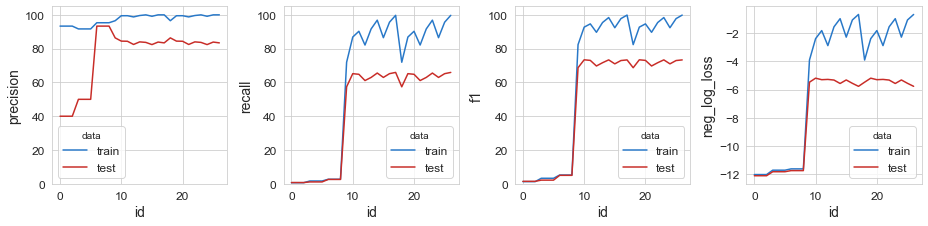

In [35]:
res = gscv_res.cv_results_

dfs = []
scoring = list(eval_metrics.keys())[:-1]
for s in scoring:
    t1 = f'mean_train_{s}'
    t2 = f'mean_test_{s}'
    t3 = ['train','test']
    df_ = pd.DataFrame([res[t1], res[t2]], index=t3).T * 100
    df_ = pd.melt(df_, var_name='data', value_name=s, value_vars=t3, ignore_index=False)
    dfs.append(df_.set_index('data', append=True))

df_ = pd.concat(dfs, axis=1).reset_index().rename(columns={'level_0':'id'}) 

fig, axs = plt.subplots(1, len(scoring), figsize=(13,3.25))
for i,s in enumerate(scoring):
    sns.lineplot(
        x='id', y=s, hue='data', data=df_, ax=axs[i], 
        palette=[CLRS['lblue'],CLRS['red']])
    if i != len(scoring)-1:
        axs[i].set_ylim(0,105)

plt.tight_layout()

#### ROC_AUC Curve

In [36]:
# make function to draw the plot ROC to easly
def plot_roc_(fpr,tpr,roc_auc):
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color=CLRS['red'], label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--', color=CLRS['lblue'])
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()

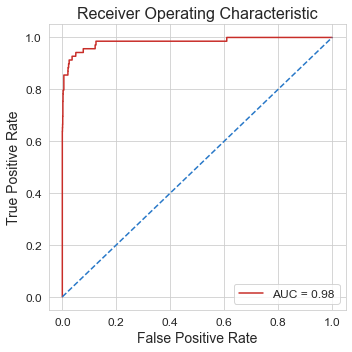

In [37]:
y_proba_log=final_model.predict_proba(x_test)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test,y_proba_log[:,1])
roc_auc_b = auc(fpr_b, tpr_b)
plot_roc_(fpr_b,tpr_b,roc_auc_b)

### Plot confusion matrix

- 0.28% false positive, 0.0021% false negative
- TODO: review other metrics such as sensitivity and specificity, when to use?

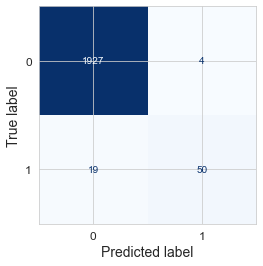

In [38]:
ax = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, colorbar=False, cmap='Blues')#, normalize='true')

### Feature Importance

NOTE: 
1. XGBoost has no internal feature importance for 'gbtree' and 'dart' boosters
2. Other options for tree-based models:
    - Mean decrease in impurity (MDI)
    - Feature permutation
    - [SHAP](https://shap.readthedocs.io/en/latest/index.html)
3. Other option is to retrain model outside of grid search using best params


TODO: 
- Do more feature importance, e.g. check p-value of the features (?), Handle featuer importance properly when there are [highly correlated features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)

#### Built-in Feature Importance

In [39]:
# XGBoost has no built-in feature importance for 'gbtree' booster
# final_model.feature_importances_.argsort()

#### SHAP-based

- TODO: Study SHAP, how it works and how to interpret results

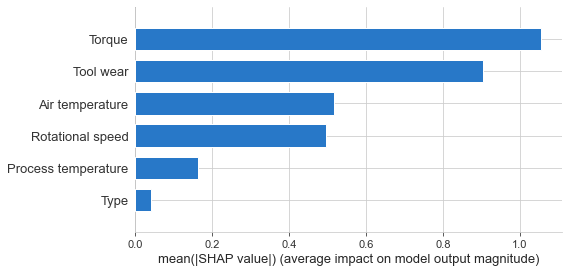

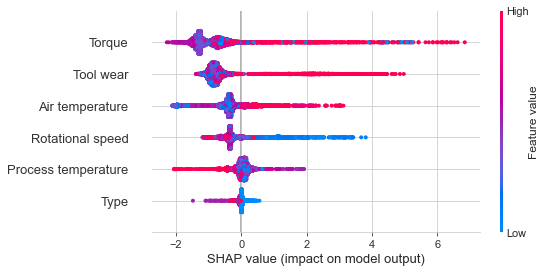

In [40]:
explainer = shap.TreeExplainer(final_model, random_state=100)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar", color=CLRS['lblue'])
shap.summary_plot(shap_values, x_train)

#### Permutation-based

- TODO: Study how this works and how to interpret results

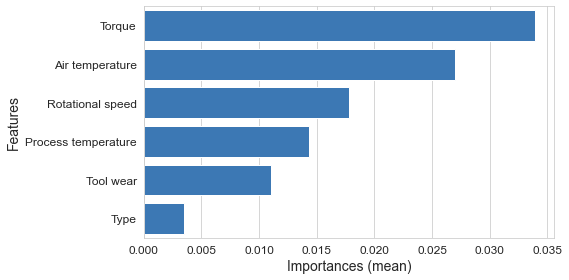

In [41]:
pi = permutation_importance(final_model, x_test, y_test, random_state=100)
pi = pd.DataFrame(
    [x_train.columns, pi['importances_mean']], 
    index=['Features', 'Importances (mean)']) \
        .T.sort_values('Importances (mean)', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(y=pi['Features'], x=pi['Importances (mean)'], orient='h', color=CLRS['lblue'])
plt.tight_layout()

### Model Scalability

- Scalability of the models in terms of computational cost e.g. training and scoring times.

In [42]:
gscv_res.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_booster', 'param_learning_rate', 'param_max_depth', 'params', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_train_precision', 'split1_train_precision', 'split2_train_precision', 'split3_train_precision', 'split4_train_precision', 'mean_train_precision', 'std_train_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_train_recall', 'split1_train_recall', 'split2_train_recall', 'split3_train_recall', 'split4_train_recall', 'mean_train_recall', 'std_train_recall', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_train_f1',

In [43]:
l = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']
for i in l:
    print(i, round(gscv_res.cv_results_[i][gscv_res.best_index_], 5), sep=':')

mean_fit_time:0.07519
std_fit_time:0.00098
mean_score_time:0.01084
std_score_time:0.00043


# Save model

In [44]:
with open('XGB_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Key Takeaways, Recommendations and Next Steps

- Trying different models, we found out that XGBoost performs best <br>
with the following metric scores during final modelling: 

        ```
        {'precision': 0.926,
        'recall': 0.725,
        'f1': 0.813,
        'neg_log_loss': 0.397,
        'pr_auc': 0.83}
        ```
Next Steps:
- Benchmark model
- Adjust probability threshold to let the business decide what works best

### TODO
1. Choose better plot colors e.g. PoerBI defaults
2. Do all TODOs and put notes for those that are new to me, e,g, how roc_auc works and how to interpret

### NOTES
- Adding duymmyfied failure types as feattures: This is highly associated with the target variable, <br>
dummyfying it would still result in leakage since the target variable would be like a linear combination of the resulting columns. 
- On oversampling the minority class: Just choose proper methods instead of creating synthetic data that could change the actual distribution of data.
- Do not touch test set other than for testing e.g. if upsampling, use only train set